<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Initial" data-toc-modified-id="Initial-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initial</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Constants" data-toc-modified-id="Constants-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Constants</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Settings" data-toc-modified-id="Settings-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Settings</a></span></li></ul></li><li><span><a href="#Read-data" data-toc-modified-id="Read-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read data</a></span></li><li><span><a href="#New-features" data-toc-modified-id="New-features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><strong>New features</strong></a></span></li><li><span><a href="#Correlation" data-toc-modified-id="Correlation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Correlation</a></span><ul class="toc-item"><li><span><a href="#Feature-correlations" data-toc-modified-id="Feature-correlations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Feature correlations</a></span></li><li><span><a href="#Correlation-to-target-&amp;-Significance-of-the-correlations" data-toc-modified-id="Correlation-to-target-&amp;-Significance-of-the-correlations-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Correlation to target &amp; Significance of the correlations</a></span></li><li><span><a href="#Outlier-significance" data-toc-modified-id="Outlier-significance-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Outlier significance</a></span></li></ul></li><li><span><a href="#Mutual-info" data-toc-modified-id="Mutual-info-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Mutual info</a></span></li><li><span><a href="#Data-save" data-toc-modified-id="Data-save-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data save</a></span></li></ul></div>

# [Cardiovascular Disease](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset) Part 2 – Feature Engineering

---

**Заказчик**

Для внутреннего (Яндекс.Практикум) соревнования [Heart diseases prediction](https://www.kaggle.com/competitions/yap15-heart-diseases-predictions).

---

**Входные данные**: параметры обследованных пациентов; данные изначально разделены на обучающий и тестовый наборы.

---

**Цель**

Predict risk of heart diseases from patient lifestyle information.  
Целевая метрика – ROC-AUC-score.

---

**Задачи:**  

- исследовать варианты создания новых признаков;
- оценить значимость исходных и новых признаков для модели;
- подготовить данные для обучения модели.

**Some explanations**

---

Permanent data tables named like: **data**.  

Temporary data tables named like: **df**.  

---

Intermediate conclusions are highlighted as follows:

> Intermediate conclusion.

---

The code of the cells are as independent as possible from each other in order to freely manipulate the cells.

---

## Intro

Features:

|                      Feature Full Name       |  Feature origin   | Feature Name |                    Data Type (units)       |
|:---------------------------------------------|:-------------------|:-----------|:--------------------------------------------|
|                      Age                      |  Objective Feature  |     age     |                    int (days)                    |
| Height                                        | Objective Feature   | height      | int (cm)                                         |
| Weight                                        | Objective Feature   | weight      | float (kg)                                       |
| Gender                                        | Objective Feature   | gender      | categorical code                                 |
| Systolic blood pressure                       | Examination Feature | ap_hi       | int                                              |
| Diastolic blood pressure                      | Examination Feature | ap_lo       | int                                              |
| Cholesterol                                   | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose                                       | Examination Feature | gluc        | 1: normal, 2: above normal, 3: well above normal |
| Smoking                                       | Subjective Feature  | smoke       | binary                                           |
| Alcohol intake                                | Subjective Feature  | alco        | binary                                           |
| Physical activity                             | Subjective Feature  | active      | binary                                           |
| Presence or absence of cardiovascular disease | Target Variable     | cardio      | binary                                           |

All of the dataset values were collected at the moment of medical examination. 

---

## Initial

### Imports

In [1]:
import pandas as pd
import numpy as np

import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio

import phik
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.decomposition import PCA

### Constants

In [2]:
PATH_LOCAL = 'datasets/'                                              # local path to data
PATH_REMOTE = '/kaggle/input/yap15-heart-diseases-predictions/'       # remote path to data

CR = '\n'                                                             # new line
RANDOM_STATE = RS = 88                                                # random_state

### Functions

In [3]:
def custom_read_csv(file_name, separator=','):
    """
    чтение датасета в формате CSV:
      сначала из локального хранилища;
      при неудаче — из удаленного хранилища Kaggle.
    """

    path_local = f'{PATH_LOCAL}{file_name}'
    path_remote = f'{PATH_REMOTE}{file_name}'
    
    if os.path.exists(path_local):
        return pd.read_csv(path_local, sep=separator)

    elif os.path.exists(path_remote):
        return pd.read_csv(path_remote, sep=separator)

    else:
        print(f'File "{file_name}" not found at the specified path ')

In [4]:
def df_name(df):
    """
    table name determination
    """
    return [name for name in globals() if globals()[name] is df][0]

In [5]:
def basic_info(df: pd.DataFrame, sample_type='sample', samples=5, describe='all'):
    """
    first info about dataframe: info(), sample()/head()/tail(), describe()
    """
    
    # title (name of dataframe)
    
    print(f'\n\ndataframe {f.BOLD}{df_name(df)}{f.END}', '≋'*30)


    # method info()
    
    print('\n\n--- method info() ---\n')
    print(df.info())

    
    # several random records
    
    print(f'\n\n--- method {sample_type}({samples}) ---')
    
    if sample_type == 'sample':
        display(df.sample(samples))
    elif sample_type == 'head':
        display(df.head(samples))
    elif sample_type == 'tail':
        display(df.tail(samples))
    else:
        print(f'{sample_type} – invalid value for parameter "sample_type" ')
    
    
    # method describe()
    
    print(f'\n\n--- method describe({describe}) ---')
    
    if describe=='all' or describe=='numeric':
        try:
            display(df.describe(include=np.number))
        except ValueError:
            pass

    if describe=='all' or describe=='categorical':
        try:
            display(df.describe(exclude=np.number).T)
        except ValueError:
            pass
    
    if describe not in ['numeric','categorical','all']:
        print(f'{describe} – invalid value for parameter "describe" ')

In [6]:
def apply_PCA(X_train, X_test, prefix='', standardize=True):
    
    # Standardize
    if standardize:
        X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
    
    # Create principal components
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Convert to dataframe
    component_names = [f'{prefix}PC{i+1}' for i in range(X_train_pca.shape[1])]
    X_train_pca = pd.DataFrame(X_train_pca, columns=component_names)
    X_test_pca = pd.DataFrame(X_test_pca, columns=component_names)
    
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,        # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X_train.columns,    # and the rows are the original features
    )
    
    return X_train_pca, X_test_pca, loadings, component_names

In [7]:
def mutual_info(X: pd.DataFrame, Y: pd.DataFrame, task=None, min_neighbors=1, max_neighbors=7):
    
    if max_neighbors < min_neighbors:
        print("Parameter 'max_neighbors' can't be less then parameter 'min_neighbors'.")
        return
    
    df_mutual_info = pd.DataFrame(index=X.columns)
    
    # Label encoding for categoricals
    for column in X.select_dtypes(exclude='number'):
        X[column], _ = X[column].factorize()

    # All discrete features should have integer dtypes
#     discrete_features_lst = (X.dtypes == int)             # маска (булевый вектор) выделяющий дискретные признаки
#     df_mutual_info[f'k_{k_neighbors}'] = mutual_info_classif(X, Y, n_neighbors=n, discrete_features=discrete_features_lst, random_state=RS)

    for k in range(min_neighbors, max_neighbors+1, 2):
        if task=='classification':
            df_mutual_info[f'k_{k}'] = mutual_info_classif(X, Y, n_neighbors=k, random_state=RS)
        elif task=='regression':
            df_mutual_info[f'k_{k}'] = mutual_info_regression(X, Y, n_neighbors=k, random_state=RS)
        else:
            print('Wrong parameter "task". Available task="classification" or task="regression".')
            return
    
    df_mutual_info['average'] = df_mutual_info.mean(axis=1)
    df_mutual_info = df_mutual_info.sort_values('average', ascending=False)
    
    display(df_mutual_info)
    
    fig, ax = plt.subplots(figsize=(15, df_mutual_info.shape[0]/3), dpi=PLOT_DPI)
    sns.barplot(x=df_mutual_info.average, y=df_mutual_info.index, color='steelblue')
    ax.set_xlabel(f'mutual_info (average across from 1 to {max_neighbors} neighbours)');

### Settings

In [8]:
# text styles
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [9]:
# defaults for charts

# Matplotlib, Seaborn
PLOT_DPI = 150  # dpi for charts rendering 
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc(
       'axes',
       labelweight='bold',
       titlesize=14,
       titlepad=10,
      )

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
                                               layout_autosize=True,
                                               # width=900,
                                               layout_height=200,
                                               layout_legend_orientation="h",
                                               layout_margin=dict(t=40, b=40),         # (l=0, r=0, b=0, t=0, pad=0)
                                               layout_template='seaborn',
                                              )
pio.templates.default = 'my_theme'

# colors, color schemes
CMAP_SYMMETRIC = LinearSegmentedColormap.from_list('', ['steelblue', 'aliceblue', 'steelblue'])

In [10]:
# Pandas defaults
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

In [11]:
# others
warnings.filterwarnings('ignore')

---

## Read data

In [12]:
data_train = custom_read_csv('EDA_train.csv')  # обучающая выборка после этапа EDA
data_test = custom_read_csv('EDA_test.csv')    # тестовая выборка после этапа EDA

Перемещение целевого признака `cardio` в начало датафрейма.

In [13]:
data_train = pd.concat([data_train[['cardio']], data_train.drop('cardio', axis=1)], axis=1)

---

## **New features**

**Списки для удобства отслеживания новых признаков**

In [14]:
new_num_features_list = []
new_cat_features_list = []

**PCA** all features

In [15]:
# feature_list = data_train.drop('cardio', axis=1).columns.to_list()

# data_train_pca, data_test_pca, loadings, columns = apply_PCA(data_train[feature_list], data_test[feature_list], prefix='')
# display(loadings)

# data_train = data_train.join(data_train_pca)
# data_test = data_test.join(data_test_pca)
# new_num_features_list = new_num_features_list + columns

In [16]:
def target_encode(df_train, df_test, feature_list, target, agg_func_list=['mean'], fill_na=0.5):
    '''
    Принимает feature_list и делает для него target encoding,
    используя заданную агрегирующую функцию agg_func.
    '''
    
    for agg_func in agg_func_list:
    
        new_feature = '_'.join(feature_list) + '_TRG_' + agg_func

        df_train[new_feature] = df_train.groupby(feature_list)[target].transform(agg_func)
        df_train[new_feature] = df_train[new_feature].fillna(fill_na)

        df_test = df_test.merge(
                                df_train[feature_list + [new_feature]].drop_duplicates(),
                                on=feature_list,
                                how="left",
                               )
        df_test[new_feature] = df_test[new_feature].fillna(fill_na)

        new_num_features_list.append(new_feature)
    
    return df_train, df_test

**Дискреизация интервальных признаков**

Оригинальный **age** имеет странные регулярные провалы – где малое количество пациентов определенного возраста. Из-за этого в местах провалов возникает риск переобучения. Дискретизация сглаживает этот деффект.

In [17]:
for df in [data_train, data_test]:
    df['weight_bined'] = pd.cut(df.weight, bins=np.linspace(0, 200, 51), labels=False)
    df['height_bined'] = pd.cut(df.height, bins=np.linspace(0, 200, 51), labels=False)
    df['age_bined'] = pd.cut(df.age, bins=np.linspace(0, 100, 51), labels=False)
    df['aphi_bined'] = pd.cut(df.ap_hi, bins=np.linspace(0, 250, 26), labels=False)
    df['aplo_bined'] = pd.cut(df.ap_lo, bins=np.linspace(0, 150, 16), labels=False)

**Сalculated features**

In [18]:
# for df in [data_train, data_test]:
    
#     df['weight_LOG'] = df.age * df.weight
#     df['weight_to_squared_height'] = df.weight / df.height**2
#     df['ap_prod'] = df.ap_hi * df.ap_lo
#     df['weight_height_ratio'] = df.weight / df.height
#     df['squared_weight_to_height'] = df.weight**2 / df.height
#     df['aphi_aplo_ratio'] = df.ap_hi / df.ap_lo
#     df['aphi_aplo_difference'] = df.ap_hi - df.ap_lo
    
# new_num_features_list.append('weight_to_squared_height')
# new_num_features_list.append('aphi_aplo_difference')

**Target Encoding: gender, aphi_bined, aplo_bined**

С дискретизацией и без нее результаты близки. Оставил с бинизацией на всякий случай.

In [19]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','aphi_bined','aplo_bined'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

**Target Encoding: gender, age**

Без дискретизации происходит overfit из-за того, что распределение возраста имеет странные разрежения.

In [20]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','age'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

**Target Encoding: gender, weight_bined, height_bined**

In [21]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','weight_bined','height_bined'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

**Target Encoding: gender, cholesterol, gluc, active**

In [22]:
data_train, data_test = target_encode(data_train, data_test,
                                      feature_list=['gender','cholesterol','gluc','active'],
                                      target='cardio', agg_func_list=['mean'], fill_na=0.5)

In [23]:
data_train.groupby(['gender','active','gluc','cholesterol']).cardio.mean().unstack()

cholesterol         1     2     3   
gender active gluc                  
0      0      1    0.512 0.700 0.768
              2    0.571 0.690 0.778
              3    0.404 0.450 0.654
       1      1    0.429 0.628 0.805
              2    0.556 0.625 0.820
              3    0.426 0.584 0.690
1      0      1    0.465 0.616 0.845
              2    0.555 0.615 0.789
              3    0.576 0.717 0.690
       1      1    0.420 0.578 0.829
              2    0.520 0.565 0.821
              3    0.463 0.599 0.698

In [24]:
# data_train, data_test = target_encode(data_train, data_test,
#                                       feature_list=['gender','cholesterol','gluc'],
#                                       target='cardio', agg_func_list=['mean'], fill_na=0.5)

In [25]:
# data_train.groupby(['gender','cholesterol','gluc']).cardio.mean().unstack()

In [26]:
# data_train, data_test = target_encode(data_train, data_test,
#                                       feature_list=['gender','cholesterol','active'],
#                                       target='cardio', agg_func_list=['mean'], fill_na=0.5)

In [27]:
# data_train.groupby(['gender','active','cholesterol']).cardio.mean().unstack()

**Target Encoding: gender, smoke, alco**

In [28]:
# data_train, data_test = target_encode(data_train, data_test,
#                                       feature_list=['gender','smoke'],
#                                       target='cardio', agg_func_list=['mean'], fill_na=0.5)

In [29]:
# data_train.groupby(['gender','smoke']).cardio.mean().unstack()

In [30]:
# data_train, data_test = target_encode(data_train, data_test,
#                                       feature_list=['gender','alco'],
#                                       target='cardio', agg_func_list=['mean'], fill_na=0.5)

In [31]:
# data_train.groupby(['gender','alco']).cardio.mean().unstack()

**new_num_features_list**

In [32]:
new_num_features_list

['gender_aphi_bined_aplo_bined_TRG_mean',
 'gender_age_TRG_mean',
 'gender_weight_bined_height_bined_TRG_mean',
 'gender_cholesterol_gluc_active_TRG_mean']

**new_cat_features_list**

In [33]:
new_cat_features_list

[]

**Drop unnecessary features**

In [34]:
data_train = data_train.drop(['age_bined', 'weight_bined', 'height_bined', 'aphi_bined', 'aplo_bined'], axis=1)

In [35]:
# feature_list = ['age','height','weight']

# data_train_pca, data_test_pca, loadings, columns = apply_PCA(data_train[feature_list], data_test[feature_list], prefix='age_height_weight_')
# display(loadings)

# data_train = data_train.join(data_train_pca)
# data_test = data_test.join(data_test_pca)
# new_num_features_list = new_num_features_list + columns

---

## Correlation

Для правильной и быстрой работы Phik необходимо указать интервальные признаки.

In [36]:
# список интервальных признаков
interval_cols_list = ['age','height','weight','ap_hi','ap_lo'] + new_num_features_list

### Feature correlations

In [37]:
# df = data_train.phik_matrix(interval_cols=interval_cols_list)

# fig, ax = plt.subplots(figsize=(15, 0.4*df.shape[1]), dpi=PLOT_DPI)
# sns.heatmap(df[(0.2 < df) & (df < 1.0)], annot=True, fmt='.2f', linewidths=0.2, annot_kws={'fontsize':10}, cmap='Blues')
# plt.show()

### Correlation to target & Significance of the correlations

Корреляция признаков с целевой переменной и нормированная статистическая значимость корреляций, а также их произведение и гармоническое среднее.

In [38]:
# по отношению к целевому признаку
# объединенная таблица корреляций и их нормированной статистической значимости
# сортировка по произведению корреляции и статистической значимости
# дополнительно: гармоническое среднее корреляции и статистической значимости
# вопрос: что более показательно – произведение или гармоническое среднее?

# correlation to target
df_1 = (data_train.phik_matrix(interval_cols=interval_cols_list)
                  .cardio
                  .to_frame()
                  .drop('cardio', axis=0)  # correlation to self
                  .rename(columns={'cardio': 'correlation'})
       )

# significance of the correlations
df_2 = (data_train.significance_matrix(interval_cols=interval_cols_list, nsim=50)
                  .cardio
                  .to_frame()
                  .drop('cardio', axis=0)  # correlation to self
                  .assign(cardio = lambda x: x.cardio / x.cardio.max())
                  .rename(columns={'cardio': 'significance'})
       )

# joined
(
    df_1.join(df_2, how='outer')
        .assign(product = lambda x: x.correlation * x.significance)
        .assign(harmonic_mean = lambda x: 2 * x.correlation * x.significance / (x.correlation + x.significance))
        .sort_values('harmonic_mean', ascending=False)
)

,correlation,significance,product,harmonic_mean
gender_aphi_bined_aplo_bined_TRG_mean,0.609,1.000,0.609,0.757
ap_hi,0.601,0.983,0.591,0.746
ap_lo,0.486,0.784,0.381,0.600
gender_age_TRG_mean,0.321,0.508,0.163,0.393
age,0.313,0.495,0.155,0.383
gender_cholesterol_gluc_active_TRG_mean,0.305,0.486,0.148,0.375
gender_weight_bined_height_bined_TRG_mean,0.282,0.449,0.127,0.346
weight,0.236,0.369,0.087,0.288
cholesterol,0.134,0.460,0.062,0.207
gluc,0.055,0.187,0.010,0.085


### Outlier significance

Поиск наиболее статистически различимых интервалов (признак и целевая переменная).

In [39]:
def plot_outlier_significance_matrix(df, feature_1, feature_2, n_bins=10):
    
    df_1 = df[[feature_1, feature_2]].outlier_significance_matrix(interval_cols=[feature_2], ndecimals=0, bins=n_bins, quantile=True)
    fig, ax = plt.subplots(figsize=(15,1), dpi=PLOT_DPI)
    sns.heatmap(df_1, annot=True, fmt='.1f', linewidths=0.2, annot_kws={'fontsize':10}, cmap=CMAP_SYMMETRIC, vmin=-75, vmax=75);
    ax.set_title(f'{feature_2}: quantile binning')

    df_2 = df[[feature_1, feature_2]].outlier_significance_matrix(interval_cols=[feature_2], ndecimals=0, bins=n_bins+1)
    fig, ax = plt.subplots(figsize=(15,1), dpi=PLOT_DPI)
    sns.heatmap(df_2, annot=True, fmt='.1f', linewidths=0.2, annot_kws={'fontsize':10}, cmap=CMAP_SYMMETRIC, vmin=-75, vmax=75)
    ax.set_title(f'{feature_2}: uniform binning')
    ax.set_xlabel(feature_2);

In [40]:
# features_to_explore = ['age','height','weight','ap_hi','ap_lo']

# for feature in features_to_explore:
#     plot_outlier_significance_matrix(df=data_train, feature_1='cardio', feature_2=feature)

Для примера: попарное сравнение признаков для обнаружения статистических отклонений.

In [41]:
# feature_1 = "ap_lo"
# feature_2 = "ap_hi"
# interval_cols_list = ["ap_hi", "ap_lo"]

# df = data_train[[feature_1, feature_2]].outlier_significance_matrix(interval_cols=interval_cols_list, ndecimals=0, bins={feature_1:3,feature_2:6})

# fig, ax = plt.subplots(figsize=(15,3), dpi=PLOT_DPI)
# sns.heatmap(df, annot=True, fmt='.1f', linewidths=0.2, annot_kws={'fontsize':10}, cmap=CMAP_SYMMETRIC, vmin=-75, vmax=75);

## Mutual info

,k_1,k_3,k_5,k_7,average
gender_aphi_bined_aplo_bined_TRG_mean,0.121,0.121,0.121,0.123,0.121
ap_hi,0.118,0.121,0.120,0.119,0.120
ap_lo,0.072,0.078,0.076,0.075,0.075
age,0.038,0.033,0.032,0.032,0.033
gender_age_TRG_mean,0.031,0.032,0.031,0.030,0.031
gender_cholesterol_gluc_active_TRG_mean,0.028,0.029,0.031,0.030,0.029
cholesterol,0.021,0.032,0.030,0.028,0.028
gender_weight_bined_height_bined_TRG_mean,0.019,0.025,0.025,0.024,0.023
weight,0.021,0.017,0.017,0.016,0.018
gluc,0.000,0.009,0.007,0.005,0.005


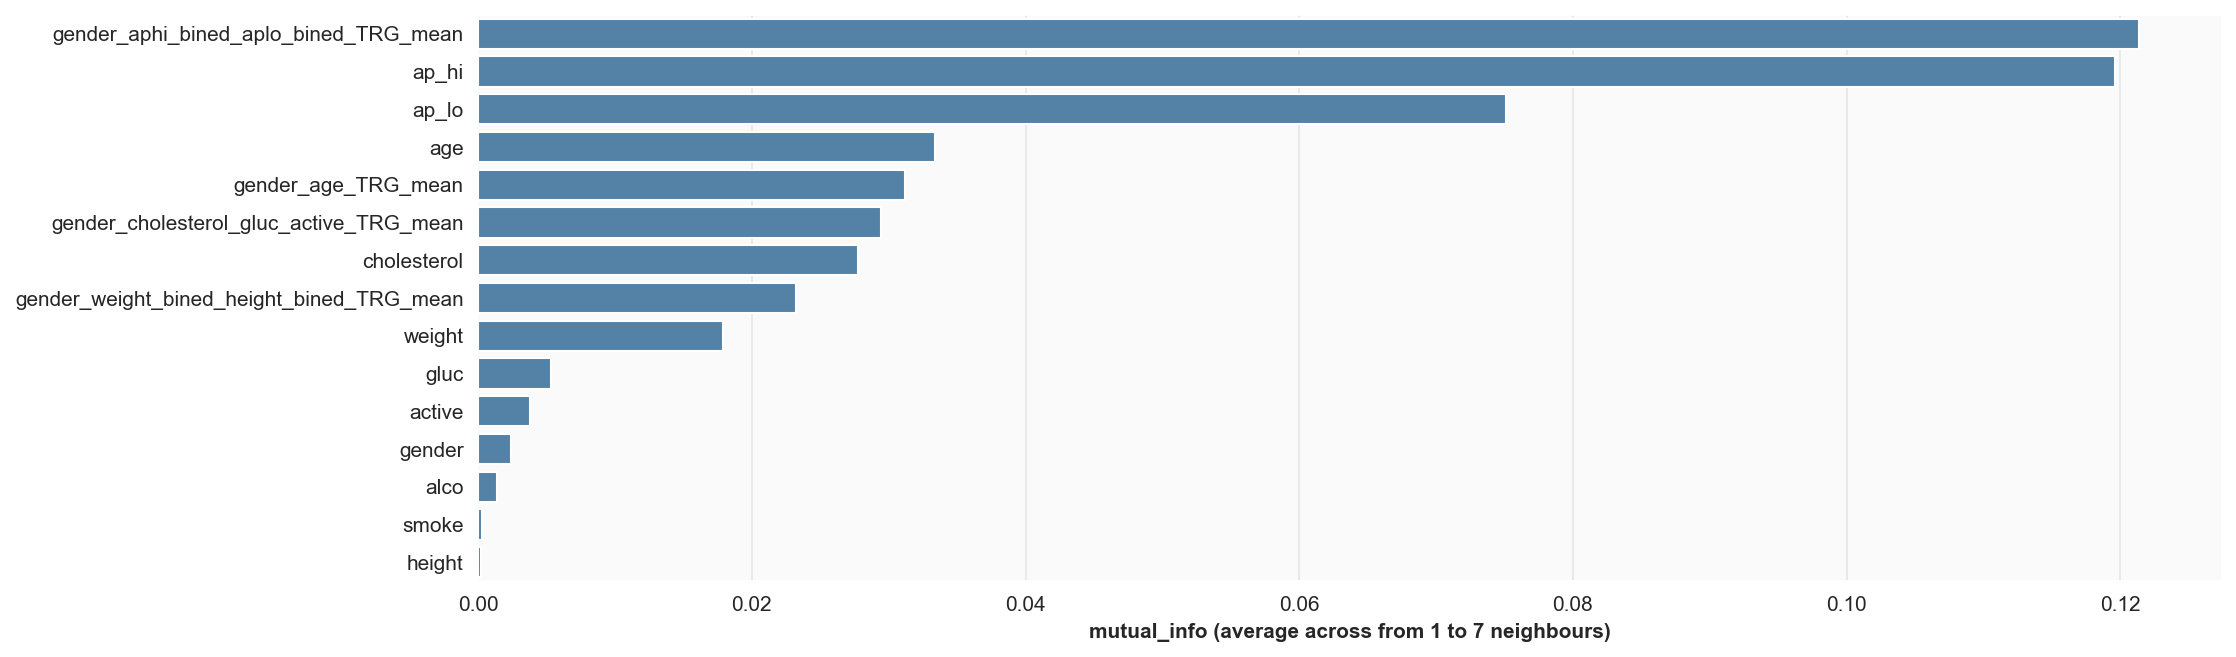

In [42]:
mutual_info(data_train.drop('cardio', axis=1), data_train.cardio, task='classification', max_neighbors=7)

## Data save

Сохранение обработанных данных для следующего этапа.

In [43]:
new_num_features_list

['gender_aphi_bined_aplo_bined_TRG_mean',
 'gender_age_TRG_mean',
 'gender_weight_bined_height_bined_TRG_mean',
 'gender_cholesterol_gluc_active_TRG_mean']

In [44]:
new_cat_features_list

[]

In [45]:
features_list = (
                 [                           # source features
#                   'age',
#                   'gender',
#                   'height',
#                   'weight',
#                   'ap_hi',
#                   'ap_lo',
#                   'cholesterol',
#                   'gluc',
#                   'smoke',
#                   'alco',
#                   'active',
                 ] +                         # new features
                 new_num_features_list
                )

In [46]:
data_train[['cardio'] + features_list].to_csv(f'datasets/FE_train.csv', index=False)
data_test[['id'] + features_list].to_csv(f'datasets/FE_test.csv', index=False)